In [1]:
# Вариант 6 - грани тэтраэдра
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd, eig, inv, sqrtm
from numpy.linalg import matrix_rank
from scipy.stats import chi2, binom, poisson
from tqdm import tqdm

In [2]:
# генерирует чистое состояние
def gen_psi(d, k):
    c = np.random.randn(d*k) + 1j*np.random.randn(d*k)
    c = c/((abs(c)**2).sum()**0.5)
    return c

# фиделити
def F(r, s):
    return abs(np.trace(sqrtm(sqrtm(r)@s@sqrtm(r)))**2)


# Функция измерения и оценки вероятности по результатам
def gen_Probs(n, rho, P_js):
    probs = [np.trace(P_j @ rho).real for P_j in P_js]
    samples = [np.random.poisson(n*prob) for prob in probs]
    
#     samples[1::2] = n - np.array(samples[0::2]) # для биномиальной статистики
    return np.array(samples)/n

# Функция псевдо-инверсии
def estimate_rho(Probs, P_js):
    B = np.reshape(P_js, (Probs.shape[0], np.prod(np.shape(P_js[0]))))
    U, S, VH = svd(B)
    q = np.conj(U.T) @ Probs
    f = q[:np.prod(np.shape(P_js[0]))]/S
    rho_est_ = np.conj(VH.T) @ f
    rho_est = np.reshape(rho_est_, (2, 2), order='F')
    return rho_est

# Создадим функцию для проецирования восстановленных матриц на
# пространство матриц плотностей
def proj_rho(rho_bad):
    ls, e_vecs = eig(rho_bad)
    idx = ls.argsort()[::-1]   
    ls = ls[idx].real
    e_vecs = e_vecs[:, idx]
    if matrix_rank(rho_bad) == 1:
        ls = np.array([1, 0])
    else:
        ws = [(np.sum(ls[:j])-1)/j for j in range(1, ls.shape[0]+1)]
        j0 = np.sum(ls - ws > 0) - 1
        ls = (ls - ws[j0])*(ls - ws > 0)   
    rho_proj = e_vecs @ np.diag(ls) @ np.conj(e_vecs.T)
    return rho_proj

# Функция очищения состояния
def purify(rho, r):
    d, u = eig(rho)
    idx = d.argsort()[::-1]   
    d = d[idx]
    u = u[:, idx]
    Psi = u @ np.reshape(np.diag(d**0.5)[:r], (d.shape[0], r))
    
    return Psi


n = 100

def J(Psi, Probs, n, P_js):
    p_js = [np.trace(P_j @ (Psi @ np.conj(Psi.T))).real for P_j in P_js]
    J_arr = [n*Probs[i]/p_js[i]*P_js[i] for i in range(Probs.shape[0])]
    return np.sum(J_arr, axis=0)

# Реконструкция состояния с помощью итерационного решения уравнения правдоподобия
def reconstruct_rho(rho, r, n, Probs, P_js):
    Psi_0 = purify(rho, r)
    Psi = Psi_0
    Psi_old = np.zeros_like(Psi)
    mu = 0.5
    eps = 1e-4

    while(np.sum(abs(Psi - Psi_old)**2)**0.5 > eps):
        Psi_old = Psi
        Psi = (1-mu)*inv_I @ J(Psi_old, Probs, n, P_js) @ Psi_old + mu*Psi_old
#         print(np.round(Psi, 2))
#         print()
    return Psi @ np.conj(Psi.T)

In [3]:
# Тэтраэдр
phis = np.array([0, 0, 2*np.pi/3, 4*np.pi/3])
thetas = np.array([0] + 3*[np.arccos(-1/3)])

phi_js = np.zeros((4, 2), dtype=complex)

phi_js[:, 0] = np.cos(thetas/2)
phi_js[:, 1] = np.sin(thetas/2)*np.exp(1j*phis)

# Составим набор проекторов
P_js = []
for phi_j in phi_js:
    P_js.append(np.outer(phi_j, np.conj(phi_j)))

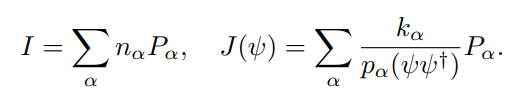

In [4]:
I = n*np.sum(P_js, axis=0)
inv_I = inv(I)

In [13]:
rs = [1, 2]

K = 1000
Fs = np.zeros((np.shape(rs)[0], K))
Fs_pinv = np.zeros(K)
p_values = np.zeros(K)
p_values_proj = np.zeros(K)
p_values_pinv = np.zeros(K)

for i in range(np.shape(rs)[0]):
    for j in tqdm(range(Fs.shape[1])):
        psi = gen_psi(2, 1)
        rho = np.outer(psi, np.conj(psi))
        Probs = gen_Probs(n, rho, P_js)
        rho_0 = proj_rho(estimate_rho(Probs, P_js))
        rho_rec = reconstruct_rho(rho_0, rs[i], n, Probs, P_js)
        rho_rec_proj = proj_rho(rho_rec)
        Fs[i, j] = F(rho_rec_proj, rho)

        if rs[i] != 2:
            Fs_pinv[j] = F(rho_0, rho)
            p_js = [np.trace(rho_rec @ P_j).real for P_j in P_js]
            chi2_value = n*np.sum((Probs - p_js)**2 / p_js)
            print(chi2_value,end=" ")
            p_js_0 = [np.trace(rho_0 @ P_j).real for P_j in P_js]
            chi2_value_0 = n*np.sum((Probs - p_js_0)**2 / p_js_0)
            print(chi2_value_0, end=" ")
            p_js_proj = [np.trace(rho_rec_proj @ P_j).real for P_j in P_js]
            chi2_value_proj = n*np.sum((Probs - p_js_proj)**2 / p_js_proj)
            print(chi2_value_proj)
            
            p_values[j] = 1 - chi2.cdf(chi2_value, 1)
            p_values_proj[j] = 1 - chi2.cdf(chi2_value_proj, 2)
            p_values_pinv[j] = 1 - chi2.cdf(chi2_value_0, 1)

  3%|██▏                                                                            | 27/1000 [00:00<00:03, 267.48it/s]

3.2524482779613013 3.658300184742548 3.397497257894186
1.03322772240386 1.735646730996368 1.1338922864532777
0.007910357502482111 0.3724380233342933 0.13271259861202173
0.24544585089732507 2.9323680685698834 2.424674038320238
2.6784769916908076 5.151048223119005 4.057414076827192
1.4468235632986621 2.0141852256555683 2.936609455373681
1.0038323704947856 4.968764923694486 4.253334169400277
0.9691728981011125 1.6126630560976365 1.5208683940269838
0.5860370883376905 5.994771318892808 5.799803027550462
2.593511340858537 4.85128751007007 3.7550571589142248
0.26275135974990016 3.998631856209864 3.943222795384538
0.6639265512223699 1.3688650405797846 1.0988032515398427
1.6386201119570394 3.57760642176179 3.0497097337846224
2.2100752610311516 4.564821114384353 3.4672188733528437
6.535437639500212e-06 2.420007279804911 2.4200072543357756
0.9473176480917229 3.600343889021345 3.483376125639658
0.4499665585871424 1.4303716279947107 1.3984689029672372
0.9875381587724693 3.3172641749301173 1.8967281

  8%|██████▋                                                                        | 84/1000 [00:00<00:03, 269.32it/s]

0.01805877434601953 7.256688019624138 4.220440252171325
0.26447617792826805 0.05072216110326524 0.2871209415263787
0.029365431801026468 1.3658542599954602e-29 0.029365431976369455
0.5701359511583114 3.330194855222309 2.835000226825117
3.7529577033708685 5.014647783548161 3.7391929395139636
0.2950629261831518 0.3956313483854725 0.3015382424924583
0.6785309322022502 5.018976539525788 4.693525267075678
1.4590497044086506 4.955200925604751 5.0287261777180685
0.008661420373485253 8.914842544037253 6.132145671863106
2.7817676603759844 5.985280178618437 5.800137879619903
0.9015047649233178 3.0819751979111616 3.011846771402015
0.7208142573220141 1.1155946994182324 1.3975654083074742
0.35272262023006273 0.6198617650165134 0.77359514150447
2.6688877509553315 3.7902968620520108 2.9537878146432526
0.8777709634089131 1.1570507283284095 0.8871598208310978
0.10840086095651212 2.332874411247736 2.324782952134086
4.634441241194006 5.884823747803371 4.608096857009121
1.078003974238173 2.0602536716416266

 14%|███████████▏                                                                  | 143/1000 [00:00<00:03, 283.03it/s]

 3.865497472959744e-29 0.9448183099374763
1.3763321056113502 2.0087572396180406 1.843267058103278
1.0827176561429837 1.5507649250989397 1.0931312519358427
0.14678676898292997 2.0731780862374554 0.6394474315517095
0.5475419505920252 0.7426848885357014 0.5475419554025078
0.7959768635438326 4.432238647772277 3.3494395302628286
0.09298576730496637 3.7696586606763867 3.7505388465389635
1.2816614976828804 2.2846000666184376 1.9571528855031863
3.3273374717406803 4.311066747277572 3.3140641149879615
0.5105318277992922 0.886343912098228 0.8101105594304374
0.14315347382784221 6.828571428571435 3.005975058375919
1.3777778816996786 7.699958668739779 4.578666761253623
1.7910147106312047 1.43342843473162 2.380565457726131
0.03439641864077514 1.17735646864114 1.1619761502348285
3.0711194358453073 5.93444042704703 4.764007503385926
0.6553500314055333 1.606703540151494 1.5894755324152319
0.18672125422772243 2.394845384918053 1.789916342556732
2.1719939934205885 1.0669960780817893 2.875814403487727
1.29

 20%|███████████████▊                                                              | 202/1000 [00:00<00:02, 285.12it/s]

3.7132390732460254 0.6888567572778079 3.8847095445604998
0.39499237506043056 0.7255819327514921 0.3949923772388687
1.2301752802354688 1.442834158300251 1.2290244101443581
0.49372315498768143 2.875417121208973 2.4443508417865454
0.5219461481582911 3.0433635275992548 2.9993602276659046
0.26471051204164825 5.04097609483879 2.8792688050130852
1.9531536022869098 2.7484812905894582 3.3973697966481793
0.032330288474538234 0.08197923342871934 0.07684533432053907
9.494752195805553 9.907423235912276 9.382383425982352
0.29695627452188905 1.4964833226237133 1.1226541183964716
2.2170373609696634 4.331503451340227 3.4735892002261077
1.1865367284780601 0.9344314222363013 1.8353445332135412
1.0098759480109842 5.693830707372767 5.66135734986331
0.23407367607517093 1.0408225117226426 0.7223699943050615
1.2910235444456304 2.199887133503576 2.9733763166349543
0.3487311644517836 0.6734758088887887 0.6059367568712071
0.01275864351404641 0.6109557778040688 0.41718450461557566
0.19344314446212812 0.3130258430

 26%|████████████████████▎                                                         | 260/1000 [00:00<00:02, 282.19it/s]

0.20469113131778685 1.2000474237715024 1.0363862095104872
0.23066708030396132 0.19272311810281634 0.36143375900490526
0.42505628501140263 2.9671498394988505 2.467561913985204
0.00026461209902927724 0.0056161125577362395 0.005265935159744259
0.10718875574418309 0.20637096938335067 0.1850449810147795
0.028307493628856862 0.35123141107520167 0.3494397934701507
3.1083587739871166 0.38397223447616485 3.552693138063849
2.418050524995086 3.78673443633371 5.2407942244469075
6.208367502048839 9.047731282115667 8.343363439129059
1.0862387510450295 2.0070502943355595 2.00184427452413
1.9998279601646087 0.5756364583955632 2.494820232004529
0.02922921733186307 0.045840324550003884 0.04952150969462289
0.23412889180930482 3.4920318452564505 3.388395005423408
2.064973974833339 3.433636523278826 3.0441973005367764
0.005787795683382857 0.13125329873740887 0.13093249060978393
2.674294766276188 3.405275199262138 3.040580049651799
3.4193012552049518 5.720610701534124 5.549134891585592
0.7176645012551011 1.

 29%|██████████████████████▌                                                       | 290/1000 [00:01<00:02, 285.89it/s]

1.5975247456025226 1.120213233347114 2.290388615497895
0.0006060622433431105 0.6061777956164089 0.6056393956701356
2.1968385507315626 2.7115319316134907 2.266917599644405
4.025151375235793 0.5796045940997777 4.726408964664115
0.16358905031558196 0.24698041300245765 0.3484967229073608
0.21647033383417122 0.009289480355974806 0.22038798356645467
0.7788445553797207 0.7987955502999825 0.7910561158188039
0.13915213047474992 4.379297106051106 4.364329190195347
3.310954575237124 3.9188666020848815 3.310954602603944
0.04702609483141281 0.9220348420530482 0.7642045294009291
0.12326344064292133 0.46275923389193646 0.3069613443927551
4.7469168169377625 8.236694087324405 6.595404788258284
1.3946092687655265 0.20583762909050454 1.484744046001313
0.16458984206981234 0.01960917236015968 0.17041279235482362
8.814715620796242 9.659424165876441 9.389538412599578
0.11916002383059793 2.6508017221246866e-29 0.11916002464705258
0.001273389629395352 0.722539155174055 0.7213497930166308
1.132101570272917 1.56

 35%|███████████████████████████▏                                                  | 348/1000 [00:01<00:02, 282.91it/s]

 1.8127274162960128
0.6841190140882814 1.7734416098381853 1.1199043738936334
0.8329131977682477 6.662110997087992 5.50881165932621
1.5394375459428333 1.2904969426708692 2.351803810680999
2.2936859173829687 3.4225844901376803 2.3101543579128436
0.03573294806713327 0.0951414734554052 0.08019695420216189
1.5879283208410588 2.211619438123688 2.0643851065575096
0.6683479354922608 4.6601640651883764 4.403574911868914
0.24399899340075584 0.5673573017195473 0.41667902543352975
0.540603393891445 0.08094445076035969 0.5774943478884644
2.1304398777833335 3.7076592218927713 2.7369618885618734
0.016083703515627556 1.591677069084529 1.1398774258435793
0.0464623616016579 1.1732342533407718 0.7636746203464573
0.4131658172213314 0.4598218124244581 0.4131658206935485
0.038282354426552166 3.106283713257476 1.1604111780389212
0.598802034413343 0.6721579740795615 0.5988020401494866
0.004370893580604983 1.682638146112195 0.504152348929088
0.19468429520460315 0.2587897020331187 0.23676403243974498
1.31702767

 40%|███████████████████████████████▌                                              | 404/1000 [00:01<00:02, 260.85it/s]

1.2884238331254103 0.6876165772588457 1.8528450368093692
0.5134811367028795 0.0073867041320761035 0.521048546216595
2.4931092339123375 4.404005067481773 3.298591597642322
0.6069545136408185 3.930344323275428 3.656085203555517
0.15703100678336063 0.3293773634129697 0.23389038788897265
3.1927418425443737 3.7366992269885553 3.533104769292169
1.0387544688469375 0.00853244018558266 1.0489482503853433
0.21342671960927648 1.1991658748759273 1.072299457815559
3.0013183280973204 5.977410637157734 5.521456781139947
1.4651437445077335 1.8869782344393535 1.4774694730639775
1.1155029201811117 0.6280349503535453 1.5707005608727609
0.15061086096187204 1.0281899350227675 1.0054005677290225
0.00027021786281934224 0.06586526008556812 0.04526616459596277
0.5362379671985215 3.010789180356407 2.4826141757415576
0.47446612741254646 0.011686513967002692 0.4770938005997845
0.4698968826048952 0.7042210259100659 0.6066443082602143
0.2754366292780198 2.821723533105575 2.725734659302888
0.31850875258512495 1.4305

 46%|████████████████████████████████████                                          | 463/1000 [00:01<00:01, 275.07it/s]

1.0771648797904305 0.3820454784211428 1.2844641194044688
0.9359378893663352 1.435516640866874 1.5997816234853044
0.00101659462201819 0.7211805091618222 0.7210775903078035
0.13533772406158093 2.0742553872833245 1.7431573296741956
1.3757931607352292 2.00735332286152 1.6689459286187216
0.2937678551793832 1.2601602165973078 0.7790794650791177
0.047677859694723435 0.38530115069044263 0.3695849742890693
4.498950856413943 4.994023622998398 4.611435160729387
0.9714287768631292 0.024245052567818476 0.9817144962078297
1.0571891609046011 2.9856945182698955 2.2614783545265396
0.16358170502994177 0.006656631804007326 0.1693996150607133
0.9647098577787067 6.258677659668835 2.321886655055424
3.760313275095603 4.64074875989362 3.8617179857935504
0.006701994764155726 0.05562260027393344 0.051802524728491776
1.9931735648885358 3.46206682206683 4.633992756957681
0.10464381974693633 0.13579027869784935 0.12569025890424007
1.1140385327121707 4.068719420225865 2.0160558399475432
1.4389626136636118 2.3475441

 49%|██████████████████████████████████████▍                                       | 492/1000 [00:01<00:01, 277.03it/s]

0.2610164838410136 1.2829992001940638 1.1229825570698846
3.1808180163888857 0.023098470157295367 3.2326262070422107
0.1863098204881661 1.857371195052947 1.6471461563904766
0.08062955728321036 3.059265722075113 1.3541791934860943
0.2015765487107048 0.7730968518070467 0.7116553776669501
0.038956258539296816 0.012406717896175517 0.04415104000007296
0.6135640172285649 0.15894735835465787 0.6677674821307017
0.08677883769616648 0.34897533643475953 0.33481609755940356
0.12882717847380384 0.2103967957791354 0.1331830436075044
1.0190650013866378 1.372513071273515 1.9277304597566607
2.2032369980486832 0.2578048645873921 2.4493341297853597
2.8686271398953935 1.1678389870686947 4.049431059966391
0.45886034955053506 1.2065441331663802 1.1513287327896173
0.7911617731504397 4.5480945205882195 3.0792337662019724
0.04347649585989452 0.6045084700546819 0.3617374363672774
1.1414157922662247 2.2554860849329295 2.041516694048144
1.3307669408027019 1.7723880976544406 1.364074620780192
1.9601810283713925 2.4

 55%|██████████████████████████████████████████▉                                   | 550/1000 [00:01<00:01, 281.04it/s]

1.6528550203015988 3.1761304359149785 2.13223351111584
1.1204022442861825 8.827358758447886 8.172676667918887
0.033875420727531795 3.424762252925373 3.4182792257333823
0.0006283788370034626 0.8457572117720411 0.845669223462003
3.1776926903078047 4.23449700792429 3.1750273192425467
0.001912947879985172 0.1271951392938138 0.12696077159399677
0.6713977036283837 0.16554603864859316 0.779612765597081
1.8254689445543955 2.716575143075283 2.4359408215837717
1.164728853213808 8.436387420455438e-29 1.164728863722953
0.00419528022430782 3.5664959854567573 2.8836918466108608
0.7703538246139121 1.3278893231716329 1.0595396783122606
0.18367739739120156 0.3498532279668283 0.4351061074964604
0.2430341027183834 2.595565451461007 2.2187306939774563
3.5764527200652556 3.911791312468088 3.6750995324806994
0.12110811187055945 0.2846292979783157 0.2974748689033545
0.16761907999998127 0.987892752408894 0.48091431801934514
0.4814413167620464 1.2911905636061083 0.8647764600528107
1.3052854129584983 0.71147482

 61%|███████████████████████████████████████████████▎                              | 607/1000 [00:02<00:01, 271.43it/s]

 1.1196061558634651 2.709308387969161
4.077050947034573 5.114350085154891e-29 4.077050985562434
0.04796722299561425 3.73980982465877 3.6994427985229845
0.0026862095631425514 3.4660431794526714 2.4223907265147706
2.720925294617117 0.11004083635662368 2.8553438240895925
0.002278669221011586 2.4229195342136403 2.4225293228509828
0.165777489171121 1.7180672268907653 0.8758308409153521
0.602738652362083 2.5411764705882285 2.168492179295705
0.8306244868831523 1.6143074554979775 1.1838494724538187
0.883461250287301 2.254316803043091 1.6710362758728847
3.475149568107462 4.208016752911462 3.460398083118627
0.24938801261547286 0.3304348983630999 0.298128834962509
0.0144099921119723 0.024833553361471354 0.03426589230106336
0.014466542928293542 2.2400837720702227 2.2209855300618595
0.5836387511482105 0.05669073453590022 0.6373933363882518
0.06525800746889975 0.748445588316137 0.24330026740485353
0.004034687697240284 0.05079679448919413 0.04909520803545559
0.0005087086326000015 0.40564903306859035 

 66%|███████████████████████████████████████████████████▊                          | 664/1000 [00:02<00:01, 270.48it/s]

1.0890826055909846 0.8390209010646594
2.5740197876276794 0.23767476945483434 2.831240403758907
0.09376747944511536 0.19359451969517844 0.11470515499941772
1.7028895225961973 0.21406244029195248 1.8169473254007844
0.10983470087729483 4.246504785641919 4.045211559801186
0.34296343740942054 0.417239932410211 0.6766819771201604
0.8559642885932032 1.5945261966436184 1.508042327552268
0.8776006142470437 0.3447044281388423 1.0918845987484216
0.25189774902159895 1.5794605394605377 1.5117459300205431
0.003773516169045236 0.39888084265964563 0.32362257554283885
1.8419575851770513 3.967706486806994 3.8219435695982527
0.05111194847504877 0.05359569971428329 0.0511119486729914
4.570872134065792 5.781402708822425 5.11876549080971
0.7119888013643246 3.3512840101075323 2.2679098149302397
0.22795726179979514 0.44709526229409124 0.3033981183495987
0.5185583742728891 2.112502083499568 1.8400430469666929
1.6875841361336255 0.1542854997121068 1.7703945488628783
2.1578839446593356 0.40883794855722705 2.4026

 69%|█████████████████████████████████████████████████████▉                        | 692/1000 [00:02<00:01, 263.41it/s]

3.502733506335967 4.097383717033678 3.8275968645849234
1.9216344995776988 0.9719749972132812 2.632324413976614
0.2753286766895056 2.511183619707471 2.302861546435136
0.07981681668449946 0.16174209264421202 0.20681223744874003
0.15008685662764057 1.082433863184825 0.7468320806593826
0.33510743046262853 4.715033312820418 4.588698009196454
2.6601215101140925 0.005902293916264725 2.651820911774134
0.5215506780997148 1.9172456230644908 1.465042135332281
1.4903505987799184 3.5221075318477937e-28 1.4903506117693133
0.3045666319369845 6.374199948936801 4.18192730532046
1.0291431238737556 1.0841884338923542 1.0291431289709878
3.1746251208370033 4.007229638074867 3.3789907741261795
0.027105443188822746 1.503372231240859 1.474409406057273
0.6697380409303312 0.10242643124665399 0.7363432839955875
0.8340458105795274 1.8043369500809707 1.733258791936412
1.0574017841906158 6.087871575181452 2.2617069276813235
0.3169355107702401 0.3941251097426342 0.31693551262037173
1.0539368796032702 1.3446572001243

 75%|██████████████████████████████████████████████████████████▏                   | 746/1000 [00:02<00:00, 254.60it/s]

 0.402605300195099 0.4010634571785316
2.3648640519641657 19.20798977390326 7.863242323369814
0.18430409090540578 1.2831982322019102 1.17720537848897
0.025592666498383564 0.8372618163261766 0.5243130334042813
0.17798036641528012 0.37529434112073506 0.30742987588029075
2.5908579717666624 0.1078282828282833 2.722675154897445
0.18697622182312806 0.3687382965956575 0.4385203904652345
0.5473594979231976 0.6473189844613279 0.6383066929176134
0.9385041352106429 1.499577132290512 1.4918864125705298
1.0745085349482846 5.365794082564632 2.280096685428757
0.37041589832045696 0.731793920077275 0.4861555034508868
0.07442403360718249 1.3604018546585803 1.3603779563601572
2.0746185445218113 0.10003885003884896 2.1961109249796924
1.4027761646223476 1.6010854770792438 1.5108316973883733
0.9630816270923046 6.26569953213405 5.917359285349749
0.11449395334972791 0.20980237302941127 0.11892148387874509
0.16883873064763555 0.17449298824756745 0.28961776358423064
0.0903335918267652 0.1320766547497166 0.109430

 80%|██████████████████████████████████████████████████████████████▌               | 802/1000 [00:02<00:00, 260.06it/s]

0.49132440967416535 1.4230870715948172 1.3682604998763768
0.9961223905603979 1.5310633110092144 1.2759866813405591
0.442250780972061 0.5577116295077325 0.5134057693744102
0.34892108042995734 0.025203562821973866 0.36543187154194406
0.521877032419869 0.2198651264435223 0.6338301110860928
0.12472885790853999 1.4502970175485483 1.2403741945994042
0.7562122534631395 1.2836528775054088 1.6503660568643532
1.2058129356485914 1.2027494108405317 1.853464169286267
0.8013934896109857 1.3979780640773807 1.3414631721016301
1.3933952031920216 2.4899040906358656 1.5315933504609542
1.4248883045866398 1.6765242672439562 1.5855105193745036
0.018876782005449143 0.08246296782461923 0.06359363039462747
4.8728329937931125 0.42931646055028594 4.997919711878909
0.830600467139113 1.4656240617294096 0.9856824612349296
0.08365565299011934 1.4013287811991046 0.9232180358827571
0.22715066409203347 6.089749404035097 2.622164092711998
0.7292979067537224 3.4879719451014624 1.4930557865204312
0.4640898142407159 0.0319

 86%|███████████████████████████████████████████████████████████████████▏          | 862/1000 [00:03<00:00, 277.28it/s]

0.28004435400417665 2.253385153381024 2.1116485694534988
0.6479151273719224 8.469758168875934 7.373050832043601
0.2940342944706408 2.6985829331366085 2.4681606949694763
0.08926260938447339 1.106838126059122 1.0755109921978574
0.006609692407095101 0.08818381959510657 0.08674188631087826
0.9182626708165044 0.08106409911617905 0.9494887392296866
1.2334016716120777 7.960530826512192 7.574246973973272
0.09074777989897935 0.017682675652442886 0.0952940418899916
0.027652062827708285 0.23988351231816057 0.2084816249049384
0.19185679263244568 2.310235321199824 2.211042473508683
0.4297138808763902 2.604993209930838 2.4726852727425164
0.020790944523989986 2.4667508905196835 2.443077948553703
1.4907111135041686 1.6325073901345442 1.495804016861186
0.5047678229910981 0.11060369674866614 0.542196310114237
0.20275081048545623 0.2592017129491735 0.2207233042858052
0.17549448584396432 0.5594282866384095 0.3607593214461107
0.2565954761024325 6.9042440466231705 2.6483699746272644
1.916978203952107 2.6890

 89%|█████████████████████████████████████████████████████████████████████▌        | 892/1000 [00:03<00:00, 282.28it/s]

0.05592887951612655 1.8948349895718322 1.0320138582413132
0.19210975357754798 7.259892150214744 4.085214389270629
1.5214995655541963 4.385783937834985 3.8862570293386147
0.9255457912064005 1.4768804983170989 1.0274071508666167
0.4763182237858393 2.3769020457295715 2.0534495872618126
0.041632328759569674 2.826084303612923e-29 0.04163232901935732
0.11854267616553647 0.5607472187258716 0.5288770976201347
0.010841565117215311 0.7493381671223552 0.7314920590748709
0.11709177085509899 0.2305375655104768 0.160335395259035
1.8022486038646701 2.4455338390564494 2.050158672550429
1.8729825435652072 3.834082642435937 3.324414126480356
5.92118909253899 8.116158089040578 7.163676169275088
0.2026903571064535 2.3859249262758078 1.4664751302177383
2.2875773462168523 5.818162838076716 3.875257518267425
0.008053651344564223 0.17638888888888682 0.08789257837124742
0.25533124901556337 1.059207599059855 0.7425646885744457
0.538752716842215 4.299928926794597 1.937958736613479
4.40570871796525 5.796657471388

 95%|██████████████████████████████████████████████████████████████████████████▏   | 951/1000 [00:03<00:00, 282.60it/s]

0.13529346494521496 0.9894048013214337 0.8471758579865648
1.2196054401996972 2.1899366769900026 1.4219192578946893
1.2637761061914328 0.9125283216671806 1.9382838044641915
0.9240058315821941 1.4829281762046163 1.4781855148316545
1.4746653091221171 3.158786799155068 3.1395721184710395
0.5039192961718082 0.9068415680843048 0.8440760723711425
0.20767703881115263 2.005819956152725 1.8089861058743557
0.7793530587087055 1.7180601149730155 1.6750110135531917
0.12719106675635772 3.1071584734379454 2.3188360057778254
0.00017409342785415578 1.620568746361755 1.6201897618365733
1.3228423484887868 3.1300343978198546 3.002172331601223
0.5116429553190616 1.9559057304669387 1.0885025952102074
1.1684304556447747 0.2572258621102847 1.322641227118428
0.5808813791774002 2.854593252057573 2.638969522711909
0.030937638109000378 0.3056050616676986 0.2770204557005158
0.010632122704712253 5.3485509197048575 3.654196786230253
0.2614660957095909 2.5534130218857927 2.2353194878838094
0.7602233701070551 1.6662195

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 274.28it/s]


0.7747711408172723 0.19387469675522945 0.8804018699401432
0.12171114775674237 0.6589589025202781 0.6277967059266998
4.161041465578382 7.742298204282061 6.361340430693829
6.65780204371779 7.182241443315183 6.763200982294509
0.23377885974868695 0.6533589271521845 0.3646233320840534
0.2731042415909791 2.139064515474289 1.6948903835112414
0.2553270854450108 0.07153964018692097 0.2964971814412709
0.28327843151394816 0.3817765991175325 0.28686204068322063
0.24247645532598144 3.5178573961672663 3.3977860142423806
0.07506729751708172 0.9758227765443501 0.790563260247993
0.04000501984932349 0.5093635810990971 0.2836048443421317
0.6890195011352613 1.5269230231395619 1.4503606774620446
0.6873976503803431 0.09607616675146836 0.7427086200101319
0.10169023371489759 0.1204400790166801 0.17965643004562035
0.1010437435248342 0.6183595959409834 0.5014967758975087
0.13122462725564205 3.28834069128023 3.2726277062769586
0.10401221529351444 4.3223949473949705 2.0936109944185803
0.05326769226411063 1.113879

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 207.35it/s]


In [18]:
Probs

array([0.18, 0.34, 0.53, 0.91])

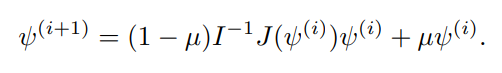

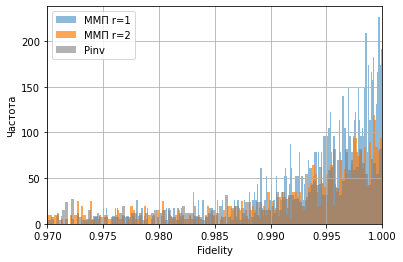

In [6]:
# Построим статистику фиделити
plt.hist(Fs[0], bins=500, alpha=0.5, density=True, label='ММП r=1')
plt.hist(Fs[1], bins=1000, alpha=0.7, density=True, label='ММП r=2')
plt.hist(Fs_pinv, bins=1000, alpha=0.6, density=True, color='grey', label='Pinv')

plt.xlim(0.97, 1)
plt.xlabel('Fidelity')
plt.ylabel('Частота')
plt.grid()
plt.legend()
plt.show()

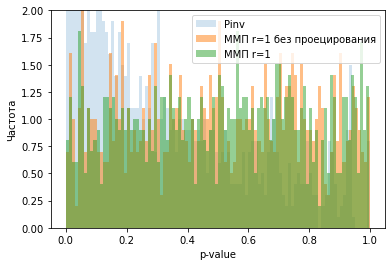

In [7]:
# Построим статистику p-value
plt.hist(p_values_pinv, bins=100, alpha=0.2, density=True, label='Pinv')
plt.hist(p_values, bins=100, alpha=0.5, density=True, label='ММП r=1 без проецирования')
plt.hist(p_values_proj, bins=100, alpha=0.5, density=True, label='ММП r=1')

plt.ylim(0, 2)
plt.xlabel('p-value')
plt.ylabel('Частота')
plt.legend()
plt.show()

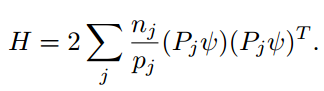

In [8]:
# Создадим матрицу полной информации
Psi_ = np.concatenate([psi.real, psi.imag])
Psi_

A = np.array([[0, -1],
              [1, 0]])
P_js_ = [np.kron(np.eye(2), P_j.real) + np.kron(A, P_j.imag) for P_j in P_js]

In [9]:
def H(Psi_, Probs, P_js_):
    return np.sum([2*n*np.outer((P_js_[i] @ Psi_), (P_js_[i] @ Psi_)) / Probs[i] for i in range(Probs.shape[0])], axis=0)

In [10]:
# Найдем ожидаемые потери точности и их отклонение
Probs = gen_Probs(n, rho, P_js)

h = H(Psi_, Probs, P_js_)
hs = eig(h)[0].real
ds = 1/2/np.sort(hs)[1:-1]

infidelity_mean = ds.sum()
infidelity_std = (2*(ds**2).sum())**0.5

In [11]:
print('r=1 F = ' + str(np.round(1 - Fs[0].mean(), 3)) + '+/-' + str(np.round((1 - Fs[0]).std(), 3)))
print('Expected F = ' + str(np.round(infidelity_mean, 3)) + '+/-' + str(np.round(infidelity_std, 3)))

r=1 F = 0.006+/-0.007
Expected F = 0.005+/-0.006
